# Read data

In [1]:
%matplotlib inline
import json
def load_simple_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)
    
words=load_simple_json('de/occupation_all.json')#{masculine:[[],[feminine]]}
words_revert={words[i][1]:i for i in words}#feminine:masculine
googlenumber=load_simple_json('de/googlenumber_new2.json')
#googlenumber_neutral=load_simple_json('de/googlenumber_neutral.json')
n_bias=load_simple_json('de/wiki/n_bias_male_labels.json')
#n_n_bias=load_simple_json('de/wiki/n_bias_n_labels.json')
f_bias=load_simple_json('de/wiki/f_bias.json')
m_bias=load_simple_json('de/wiki/m_bias.json')

google_percent={}
for i in googlenumber:
    sum_m_f=float(int(googlenumber[i][0])+int(googlenumber[i][1]))
    google_percent[i]=(float(googlenumber[i][0])-float(googlenumber[i][1]))/sum_m_f if sum_m_f!=0 else 0

google_rank_male={}
for i in words:
    if i in f_bias:
        google_rank_male[i]=[int(googlenumber[i][0]),len(i),google_percent[i],3] #3=female bias
    elif i in m_bias:
        google_rank_male[i]=[int(googlenumber[i][0]),len(i),google_percent[i],1] #1=male bias
    elif i in n_bias:
        google_rank_male[i]=[int(googlenumber[i][0]),len(i),google_percent[i],2] #2=no bias
n_male=sum( n == 1 for x,y,z,n in google_rank_male.values())
n_female=sum( n == 3 for x,y,z,n in google_rank_male.values())      
n_neutral=sum( n == 2 for x,y,z,n in google_rank_male.values())
print "Male bias:",n_male,", Female bias:",n_female,", No bias:",n_neutral
print "All:",len(google_rank_male)  
#Male bias: 812 , Female bias: 6 , No bias: 19 All: 837

Male bias: 812 , Female bias: 6 , No bias: 19
All: 837


       GoogleHitsMale  Name_length  NormalizedGoogleDif        Wiki
count    8.370000e+02   837.000000           837.000000  837.000000
mean     1.375604e+06    15.433692             0.694513    1.037037
std      9.570879e+06     8.112809             0.383918    0.223745
min      1.300000e+01     3.000000            -0.993448    1.000000
25%      2.560000e+03    10.000000             0.592668    1.000000
50%      1.720000e+04    13.000000             0.848124    1.000000
75%      1.390000e+05    18.000000             0.947315    1.000000
max      1.610000e+08    60.000000             1.000000    3.000000
GoogleHitsMale         9570879.397740
Name_length                  8.112809
NormalizedGoogleDif          0.383918
Wiki                         0.223745
dtype: float64


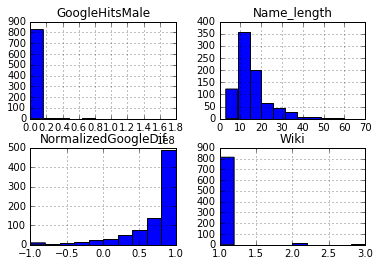

In [2]:
import pandas as pd
import pylab as pl
import numpy as np

df = pd.DataFrame.from_dict(google_rank_male,orient='index')
df.columns = ['GoogleHitsMale','Name_length', 'NormalizedGoogleDif','Wiki']
# summarize the data
print df.describe()

# take a look at the standard deviation of each column
print df.std()
#print pd.crosstab(df['Wiki'], df['GooglePercent'])
df.hist()
pl.show()

In [3]:
df[df.Wiki==3]

,GoogleHitsMale,Name_length,NormalizedGoogleDif,Wiki
Beschließer,255,11,-0.320905,3
Pflegediensthelfer,2120,18,-0.252205,3
Entbindungspfleger,26700,18,-0.908827,3
Haushälter,8000,10,-0.807229,3
Gleichstellungsbeauftragter,2490,27,-0.957971,3
Belegentbindungspfleger,47,23,-0.993448,3


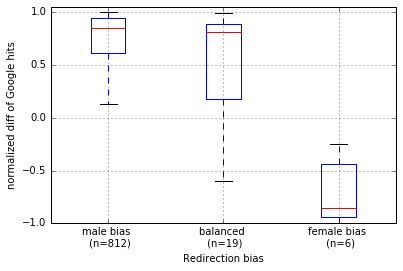

In [4]:
data1= df[['NormalizedGoogleDif','Wiki']]
bp = data1.boxplot(by='Wiki',showfliers=False)
pl.ylim(ymax=1.05)
pl.ylabel("normalized diff of Google hits")
pl.xlabel("Redirection bias")
pl.title("")
pl.suptitle("")
pl.xticks([1,2,3],["male bias \n (n={0})".format(n_male),"balanced \n (n={0})".format(n_neutral),
                   "female bias \n (n={0})".format(n_female)])
pl.show()

In [5]:
data1.groupby("Wiki").median()

,NormalizedGoogleDif
Wiki,
1,0.854215
2,0.810562
3,-0.858028


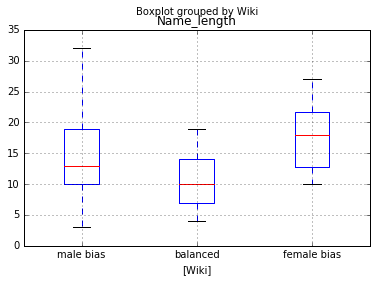

In [6]:
data1= df[['Name_length','Wiki']]
bp = data1.boxplot(by='Wiki',showfliers=False)
pl.xticks([1,2,3],["male bias","balanced","female bias"])
pl.show()

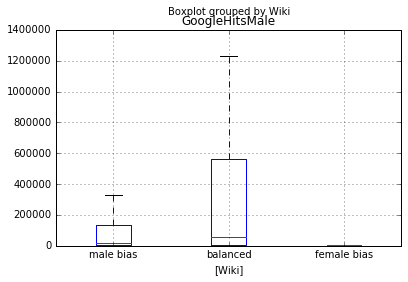

In [7]:
data1= df[['GoogleHitsMale','Wiki']] #google results for male labels
bp = data1.boxplot(by='Wiki',showfliers=False)
pl.xticks([1,2,3],["male bias","balanced","female bias"])
pl.show()

# Logistic Regression (Male bias) 

In [ ]:
#DEPENDENT VARIABLES:
#male exist AND (no female OR female label redirects to male label) => male bias => 1
#female exist AND (no male OR male label redirects to female label)  => female bias => 3

#INDEPENDENT VARIABLES:
#Google hits for male label
#normalized difference between google hits of male and female label

In [83]:
data = df
dummy_wiki = pd.get_dummies(data['Wiki'], prefix='Wiki')
y_all=[dummy_wiki["Wiki_3"],dummy_wiki["Wiki_1"]]
y=y_all[1]
X=data[['NormalizedGoogleDif',"GoogleHitsMale"]]#"Name_length"
X=sm.add_constant(X, prepend=False)
X=X.rename(columns = {'const':'intercept'})
res1 = sm.Logit(y,X)
mlogit_res = res1.fit()
print mlogit_res.params
print mlogit_res.summary()
predict= np.array(mlogit_res.predict() > 0.5, dtype=float)
print mlogit_res.pred_table()

Optimization terminated successfully.
         Current function value: 0.115416
         Iterations 8
NormalizedGoogleDif    2.046990e+00
GoogleHitsMale        -2.135595e-08
intercept              2.518450e+00
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                 Wiki_1   No. Observations:                  837
Model:                          Logit   Df Residuals:                      834
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Sep 2016   Pseudo R-squ.:                  0.1405
Time:                        23:52:02   Log-Likelihood:                -96.603
converged:                       True   LL-Null:                       -112.40
                                        LLR p-value:                 1.383e-07
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------

In [84]:
X=data[['NormalizedGoogleDif',"Name_length","GoogleHitsMale"]]
X=sm.add_constant(X, prepend=False)
X=X.rename(columns = {'const':'intercept'})
res1 = sm.Logit(y,X)
mlogit_res = res1.fit()
print mlogit_res.summary()
predict= np.array(mlogit_res.predict() > 0.5, dtype=float)
print mlogit_res.pred_table()

Optimization terminated successfully.
         Current function value: 0.102696
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 Wiki_1   No. Observations:                  837
Model:                          Logit   Df Residuals:                      833
Method:                           MLE   Df Model:                            3
Date:                Fri, 23 Sep 2016   Pseudo R-squ.:                  0.2352
Time:                        23:52:30   Log-Likelihood:                -85.957
converged:                       True   LL-Null:                       -112.40
                                        LLR p-value:                 1.945e-11
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
NormalizedGoogleDif     3.0303      0.452      6.712      0.000         2.145     3.915
Na

# Logistic Regression (Female bias)

In [33]:
data = df
dummy_wiki = pd.get_dummies(data['Wiki'], prefix='Wiki')
y_all=[dummy_wiki["Wiki_3"],dummy_wiki["Wiki_1"]]
y=y_all[0]
X=data[['NormalizedGoogleDif',"GoogleHitsMale"]]
X=sm.add_constant(X, prepend=False)
X=X.rename(columns = {'const':'intercept'})

res1 = sm.Logit(y,X)
mlogit_res = res1.fit()
print mlogit_res.summary()
predict= np.array(mlogit_res.predict() > 0.5, dtype=float)
print mlogit_res.pred_table()
acc=float(sum(mlogit_res.pred_table().diagonal()))/float(len(y))
print "Accuracy:",acc   

print "Odds:\n", np.exp(mlogit_res.params)
print "p:\n", np.exp(mlogit_res.params)/(1+np.exp(mlogit_res.params))
print "Probability of being in a Female Bias class when Normalized GoogleDif increase by a unit is 0.006"
print "Probability of being in a Female Bias class given normalozedGoogleDif==0 is 0.009"

Optimization terminated successfully.
         Current function value: 0.018299
         Iterations 18
                           Logit Regression Results                           
Dep. Variable:                 Wiki_3   No. Observations:                  837
Model:                          Logit   Df Residuals:                      834
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Sep 2016   Pseudo R-squ.:                  0.5699
Time:                        23:11:37   Log-Likelihood:                -15.316
converged:                       True   LL-Null:                       -35.607
                                        LLR p-value:                 1.541e-09
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
NormalizedGoogleDif    -4.9650      1.383     -3.589      0.000        -7.676    -2.254
G

# Logistic Regression (Male bias)  without neotral group

In [35]:
data = df[df.Wiki!=2]
dummy_wiki = pd.get_dummies(data['Wiki'], prefix='Wiki')
y_all=[dummy_wiki["Wiki_3"],dummy_wiki["Wiki_1"]]
y=y_all[1]
X=data[['NormalizedGoogleDif']]
X=sm.add_constant(X, prepend=False)
X=X.rename(columns = {'const':'intercept'})
res1 = sm.Logit(y,X)
mlogit_res = res1.fit()
print mlogit_res.summary()
predict= np.array(mlogit_res.predict() > 0.5, dtype=float)
print mlogit_res.pred_table()

Optimization terminated successfully.
         Current function value: 0.018498
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                 Wiki_1   No. Observations:                  818
Model:                          Logit   Df Residuals:                      816
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 Sep 2016   Pseudo R-squ.:                  0.5734
Time:                        23:13:05   Log-Likelihood:                -15.131
converged:                       True   LL-Null:                       -35.469
                                        LLR p-value:                 1.798e-10
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
NormalizedGoogleDif     5.3080      1.414      3.755      0.000         2.537     8.079
i

# With stratified k-folds

## Male bias

Optimization terminated successfully.
         Current function value: 0.115660
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114301
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120720
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.103474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120680
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Wiki_1   No. Observations:                  670
Model:                          Logit   Df Residuals:                      667
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Sep 2016   Pseudo R-squ.:                  0.2291
Time:                        23:26:53   Log-Likelihood:                -69.328
converged:      

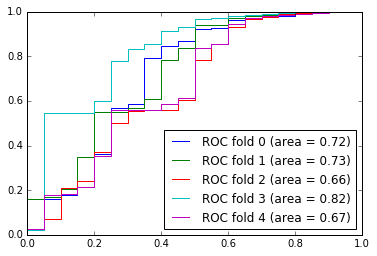

In [61]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
data = df
dummy_wiki = pd.get_dummies(data['Wiki'], prefix='Wiki')
y_all=[dummy_wiki["Wiki_3"],dummy_wiki["Wiki_1"]]
y=y_all[1]
X=data[['NormalizedGoogleDif',"GoogleHitsMale" ]]#[train_cols]
X=sm.add_constant(X, prepend=False)
X=X.rename(columns = {'const':'intercept'})
skf = cross_validation.StratifiedKFold(y, n_folds=5,shuffle=True)
aic_min=9999
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
i=0
for train_index, test_index in skf:  
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]

    res1 = sm.Logit(y_train, X_train)
    mlogit_res = res1.fit()
    predict= np.array(mlogit_res.predict() > 0.5, dtype=float)
    #print mlogit_res.summary()
    #print mlogit_res.pred_table()
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[train_index], mlogit_res.predict())
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    aic=mlogit_res.aic
    i+=1
    if aic<aic_min:
        aic_min=aic
        best_res=mlogit_res
        y_train_best=y_train
        best_index=train_index
print best_res.summary()
print "AIC:",best_res.aic
print "BIC:",best_res.bic
predict= np.array(best_res.predict() > 0.5, dtype=float)
print best_res.pred_table()
acc=float(sum(best_res.pred_table().diagonal()))/float(len(y_train_best))
print "Accuracy:",acc
print "Odds:\n", np.exp(best_res.params)
print "p:\n", np.exp(best_res.params)/(1+np.exp(best_res.params))
plt.legend(loc="lower right")

In [43]:
print best_res.summary2()
print best_res.pvalues

                          Results: Logit
Model:                   Logit     Pseudo R-squared:    0.212     
Dependent Variable:      Wiki_1    AIC:                 147.7394  
No. Observations:        670       BIC:                 161.2613  
Df Model:                2         Log-Likelihood:      -70.870   
Df Residuals:            667       LL-Null:             -89.929   
Converged:               1.0000    LLR p-value:         5.2782e-09
No. Iterations:          8.0000    Scale:               1.0000    
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
NormalizedGoogleDif  2.4409   0.3884  6.2840 0.0000  1.6796 3.2022
GoogleHitsMale      -0.0000   0.0000 -0.0063 0.9949 -0.0000 0.0000
intercept            2.4078   0.2496  9.6481 0.0000  1.9187 2.8969

NormalizedGoogleDif    3.298758e-10
GoogleHitsMale         9.949428e-01
intercept      

                          Results: Logit
==================================================================
Model:                   Logit     Pseudo R-squared:    0.212     
Dependent Variable:      Wiki_1    AIC:                 147.7394  
No. Observations:        670       BIC:                 161.2613  
Df Model:                2         Log-Likelihood:      -70.870   
Df Residuals:            667       LL-Null:             -89.929   
Converged:               1.0000    LLR p-value:         5.2782e-09
No. Iterations:          8.0000    Scale:               1.0000    
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
NormalizedGoogleDif  2.4409   0.3884  6.2840 0.0000  1.6796 3.2022
GoogleHitsMale      -0.0000   0.0000 -0.0063 0.9949 -0.0000 0.0000
intercept            2.4078   0.2496  9.6481 0.0000  1.9187 2.8969
==================================================================

NormalizedGoogleDif    3.298758e-10
GoogleHitsMale         9.949428e-01
intercept              5.005866e-22
dtype: float64


 the odds of being in a male bias for females (female = 1)over the odds of getting into an honors class for males (female = 0) is exp(.979948) = 2.66.  In terms of percent change, we can say that the odds for females are 166% higher than the odds for males.

Model 1:
The coefficient for Normalized Google difference says that, we will see 1048% increase in the odds of being in a male bias group for a one-unit increase in Normalized Google difference score since exp(2.44) = 11.48.


Model 2:
The coefficient for Normalized Google difference says that, we will see 0.02% increase in the odds of being in a female bias group for a one-unit increase in Normalized Google difference score since exp(-5.93) = 0.002654.


|           | Coef. | p | 95% Conf. int. |
|:-:|:-:|:-:|:-:|
| Model 1:|| Accuracy: 0.971 | Pseudo R-squared:  0.21|
| Normalized Google difference | 2.44  |    0.0000       |  [ 1.68, 3.20 ]     |
| Google hits for male name |    0.00    |       0.9949    |    [ 0.00, 0.00 ]   |
| (Intercept)  |     2.41    |       0.0000       |     [ 1.92, 2.90]   |
| ||||
| Model 2:|| Accuracy: 0.995| Pseudo R-squared:  0.62|
| Normalized Google difference | -5.93  |    0.006       |  [ -10.13, -1.73 ]     |
| Google hits for male name |    -2.075e-05 |     0.558    |    [ -9.02e-05, 4.87e-05 ]   |
| (Intercept)  |     -5.5543     |       0.001    |     [ -8.872, -2.236]   |





## Female bias

Optimization terminated successfully.
         Current function value: 0.017791
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.020187
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.016530
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.018319
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.017397
         Iterations 18
NormalizedGoogleDif   -5.931675
GoogleHitsMale        -0.000021
intercept             -5.554297
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                 Wiki_3   No. Observations:                  670
Model:                          Logit   Df Residuals:                      667
Method:                           MLE   Df Model:                            2
Date:                Tue, 09 Feb 2016   Pseudo R-squ.:    

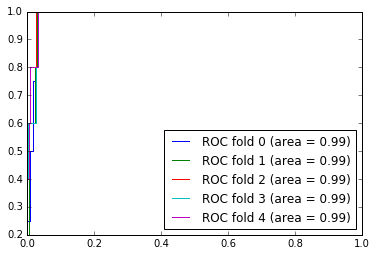

In [298]:
data = df

dummy_wiki = pd.get_dummies(data['Wiki'], prefix='Wiki')
y_all=[dummy_wiki["Wiki_3"],dummy_wiki["Wiki_1"]]
y=y_all[0]
X=data[['NormalizedGoogleDif',"GoogleHitsMale" ]]#[train_cols]
X=sm.add_constant(X, prepend=False)
X=X.rename(columns = {'const':'intercept'})
skf = cross_validation.StratifiedKFold(y, n_folds=5,shuffle=True)
aic_min=9999
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
i=0
for train_index, test_index in skf:  
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]

    res1 = sm.Logit(y_train, X_train)
    mlogit_res = res1.fit()
    predict= np.array(mlogit_res.predict() > 0.5, dtype=float)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[train_index], mlogit_res.predict())
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    aic=mlogit_res.aic
    i+=1
    if aic<aic_min:
        aic_min=aic
        best_res=mlogit_res
        y_train_best=y_train
        best_index=train_index
print best_res.summary()
print "AIC:",best_res.aic
print "BIC:",best_res.bic
predict= np.array(best_res.predict() > 0.5, dtype=float)
print best_res.pred_table()
acc=float(sum(best_res.pred_table().diagonal()))/float(len(y_train_best))
print "Accuracy:",acc
print "Odds:\n", np.exp(best_res.params)
print "p:\n", np.exp(best_res.params)/(1+np.exp(best_res.params))


plt.legend(loc="lower right")



# Without neutral case

## Logistic Regression (Male bias)  without neotral group

In [62]:
data = df[df.Wiki!=2]
dummy_wiki = pd.get_dummies(data['Wiki'], prefix='Wiki')
y_all=[dummy_wiki["Wiki_3"],dummy_wiki["Wiki_1"]]
y=y_all[1]
X=data[['NormalizedGoogleDif',"GoogleHitsMale" ]]#,"Name_length"]]
X=sm.add_constant(X, prepend=False)
X=X.rename(columns = {'const':'intercept'})
skf = cross_validation.StratifiedKFold(y, n_folds=5,shuffle=True)
aic_min=9999
for train_index, test_index in skf:  
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    res1 = sm.Logit(y_train, X_train)
    mlogit_res = res1.fit()
    aic=mlogit_res.aic
    if (aic<aic_min)&(mlogit_res.mle_retvals["iterations"]!=35):
        aic_min=aic
        best_res=mlogit_res
        y_train_best=y_train
print best_res.summary()
print "AIC:",best_res.aic
print "BIC:",best_res.bic
predict= np.array(best_res.predict() > 0.5, dtype=float)
print best_res.pred_table()
acc=float(sum(best_res.pred_table().diagonal()))/float(len(y_train_best))
print "Accuracy:",acc
print "Odds:\n", np.exp(best_res.params)
print "p:\n", np.exp(best_res.params)/(1+np.exp(best_res.params))

Optimization terminated successfully.
         Current function value: 0.013276
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.019461
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.015957
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.020928
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.019936
         Iterations 20
                           Logit Regression Results                           
Dep. Variable:                 Wiki_1   No. Observations:                  653
Model:                          Logit   Df Residuals:                      650
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Sep 2016   Pseudo R-squ.:                  0.6442
Time:                        23:30:58   Log-Likelihood:                -8.6695
converged: 

## Logistic Regression (Female bias)  without neotral group

Optimization terminated successfully.
         Current function value: 0.017972
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.020214
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.014578
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.020610
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.016035
         Iterations 17
                           Logit Regression Results                           
Dep. Variable:                 Wiki_1   No. Observations:                  655
Model:                          Logit   Df Residuals:                      652
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Sep 2016   Pseudo R-squ.:                  0.6747
Time:                        23:32:56   Log-Likelihood:                -9.5483
converged: 

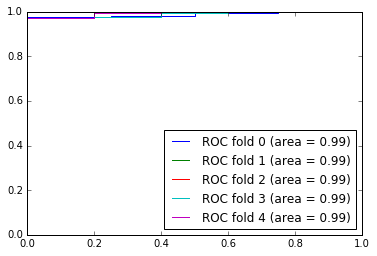

In [65]:
data = df[df.Wiki!=2]

dummy_wiki = pd.get_dummies(data['Wiki'], prefix='Wiki')
y_all=[dummy_wiki["Wiki_3"],dummy_wiki["Wiki_1"]]
y=y_all[1]
X=data[['NormalizedGoogleDif',"GoogleHitsMale" ]]#[
X=sm.add_constant(X, prepend=False)
X=X.rename(columns = {'const':'intercept'})
skf = cross_validation.StratifiedKFold(y, n_folds=5,shuffle=True)
aic_min=9999
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
i=0
for train_index, test_index in skf:  
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    res1 = sm.Logit(y_train, X_train)
    mlogit_res = res1.fit()
    
    predict= np.array(mlogit_res.predict() > 0.5, dtype=float)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[train_index], mlogit_res.predict())
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    aic=mlogit_res.aic
    i+=1
    if aic<aic_min:
        aic_min=aic
        best_res=mlogit_res
        y_train_best=y_train
        best_index=train_index
print best_res.summary()
print "AIC:",best_res.aic
print "BIC:",best_res.bic
predict= np.array(best_res.predict() > 0.5, dtype=float)
print best_res.pred_table()
acc=float(sum(best_res.pred_table().diagonal()))/float(len(y_train_best))
print "Accuracy:",acc
print "Odds:\n", np.exp(best_res.params)
print "p:\n", np.exp(best_res.params)/(1+np.exp(best_res.params))


plt.legend(loc="lower right")



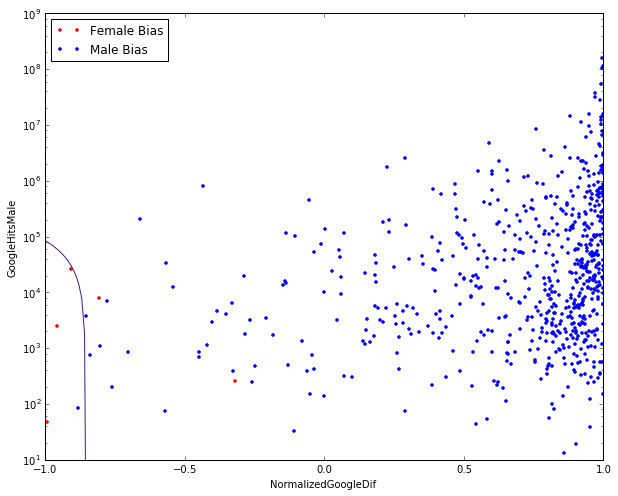

In [82]:
logit_pars = best_res.params
intercept = -logit_pars['intercept'] / logit_pars['GoogleHitsMale']
slope = -logit_pars['NormalizedGoogleDif'] / logit_pars['GoogleHitsMale']
heights_f=X_train[y_train!=1].NormalizedGoogleDif.values
weights_f=X_train[y_train!=1].GoogleHitsMale.values
heights_m=X_train[y_train==1].NormalizedGoogleDif.values
weights_m=X_train[y_train==1].GoogleHitsMale.values

fig = plt.figure(figsize = (10, 8))

plt.semilogy()
plt.plot(heights_f, weights_f, '.', label = 'Female Bias',c='r')
# Men points (blue)
plt.plot(heights_m, weights_m, '.', label = 'Male Bias',c="b")#,mfc = 'None', mec='steelblue', alpha = .4)
# The separating line
y=intercept +slope * np.arange(-1,1.01,0.01) 
y[y < 0] = 0.0001
plt.plot(np.arange(-1,1.01,0.01), y,'-', color = '#461B7E')
plt.xlabel('NormalizedGoogleDif ')
plt.ylabel('GoogleHitsMale')
plt.ylim(10)
plt.xlim(-1,1)
plt.legend(loc='upper left')

# plot all data

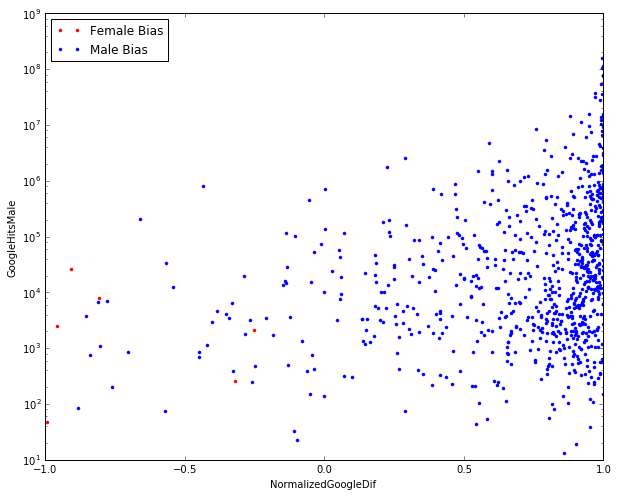

In [289]:
heights_f=data[data.Wiki==3].NormalizedGoogleDif.values
weights_f=data[data.Wiki==3].GoogleHitsMale.values
heights_m=data[data.Wiki==1].NormalizedGoogleDif.values
weights_m=data[data.Wiki==1].GoogleHitsMale.values
fig = plt.figure(figsize = (10, 8))
plt.semilogy()
plt.plot(heights_f, weights_f, '.', label = 'Female Bias',c='r')
plt.plot(heights_m, weights_m, '.', label = 'Male Bias',c="b")
plt.xlabel('NormalizedGoogleDif ')
plt.ylabel('GoogleHitsMale')
plt.legend(loc='upper left')

In [85]:
params = best_res.params
conf = best_res.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                         2.5%         97.5%          OR
NormalizedGoogleDif  9.263405  30525.481686  531.761126
GoogleHitsMale       0.999960      1.000061    1.000011
intercept            9.466186   4955.744621  216.591783


# Multinomial logistic regression

In [13]:
from sklearn import cross_validation
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

data = df[['GoogleHitsMale', 'Name_length', 'NormalizedGoogleDif','Wiki']]
data=sm.add_constant(data, prepend=False)
print "Wiki=1, i.e., male bias is the reference group while it is the most frequent one."
print data.head()

data=sm.add_constant(data, prepend=False)
cols_to_keep = ['GoogleHitsMale','NormalizedGoogleDif','Name_length','const']


y=data['Wiki']
X=data[cols_to_keep]

skf = cross_validation.StratifiedKFold(y, n_folds=2,shuffle=True)
for train_index, test_index in skf:  
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    print "train:",len(y_train), "test:",len(y_test)
    res1 = sm.MNLogit(y_train, X_train) 
    mlogit_res = res1.fit()
    print mlogit_res.params
    print mlogit_res.summary()
    print "AIC:",mlogit_res.aic
    print "BIC:",mlogit_res.bic
    
    mlogit_margeff = mlogit_res.get_margeff()
    print mlogit_margeff.summary()

    predict= np.array(mlogit_res.predict() > 0.5, dtype=float)
    print mlogit_res.pred_table()
    acc=float(sum(mlogit_res.pred_table().diagonal()))/float(len(y_train))
    print "Accuracy:",acc
    
# odds ratios only
print np.exp(mlogit_res.params)
#pd.save(df, 'de/values_googlenumber_pred.csv')

Wiki=1, i.e., male bias is the reference group while it is the most frequent one.
                         GoogleHitsMale  Name_length  NormalizedGoogleDif  \
Fahrzeuginnenausstatter            3130           23             0.846608   
Audiodesigner                      1450           13             0.948925   
Jäger                           2350000            5             0.959803   
Zusteller                        596000            9             0.985839   
Revierjäger                        3930           11             0.867871   

                         Wiki  const  
Fahrzeuginnenausstatter     1      1  
Audiodesigner               2      1  
Jäger                       1      1  
Zusteller                   1      1  
Revierjäger                 1      1  
train: 418 test: 419
         Current function value: 0.089841
         Iterations: 35
                                0           1
GoogleHitsMale       4.326163e-09    0.000005
NormalizedGoogleDif -2.107869e+00 -203.868

In [15]:
###we exclude neutral case
data = df[df.Wiki!=2]

y=data['Wiki']
X=data[['NormalizedGoogleDif']]
X=sm.add_constant(X, prepend=False)
res1 = sm.MNLogit(y,X)
mlogit_res = res1.fit()
print mlogit_res.params
print mlogit_res.summary()
print "AIC:",mlogit_res.aic
print "BIC:",mlogit_res.bic

predict= np.array(mlogit_res.predict() > 0.5, dtype=float)
print mlogit_res.pred_table()
acc=float(sum(mlogit_res.pred_table().diagonal()))/float(len(y))
print "Accuracy:",acc

Optimization terminated successfully.
         Current function value: 0.018498
         Iterations 12
                            0
NormalizedGoogleDif -5.307972
const               -5.065929
                          MNLogit Regression Results                          
Dep. Variable:                   Wiki   No. Observations:                  818
Model:                        MNLogit   Df Residuals:                      816
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 Sep 2016   Pseudo R-squ.:                  0.5734
Time:                        22:43:28   Log-Likelihood:                -15.131
converged:                       True   LL-Null:                       -35.469
                                        LLR p-value:                 1.798e-10
             Wiki=3       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------